In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D 

plt.style.use('seaborn')

## Exercise 8
Train a LinearSVC on a linearly separable dataset, Then train an SVC and a SGDClassifier on the same dataset. See if you can get them to produce roughly the same model

## A) An easy linearly separable dataset

Let's start by creating a linearly separable dataset

In [2]:
def rand_circle(x0, y0, circle_r,  n_samples=1000):
    xs, ys = [], []
    while len(xs) < n_samples:
        alpha = 2 * math.pi * np.random.rand() 
        r = circle_r * math.sqrt(np.random.rand())
        x = r * math.cos(alpha) + x0
        y = r * math.sin(alpha) + y0
        
        xs.append(x) #+ np.random.rand())
        ys.append(y) #+ np.random.rand())
    return xs, ys

In [3]:
class_a_params = {'x0':-2, 'y0':15, 'circle_r':19, 'n_samples':1000}
class_b_params = {'x0':13, 'y0':-8, 'circle_r':8, 'n_samples':1000}

xa, ya = rand_circle(**class_a_params)
xb, yb = rand_circle(**class_b_params)

In [4]:
def plot_circle_dataset(xa, xb, ya, yb):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.scatter(xa, ya, marker='o')
    ax.scatter(xb, yb, marker='^')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

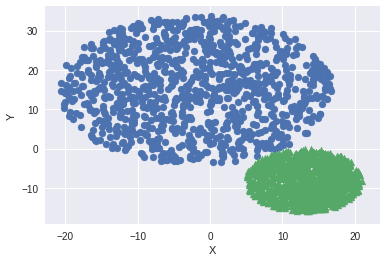

In [5]:
plot_circle_dataset(xa, xb, ya, yb)

The above are just barely linearly separable, let's see how we do! Start by building our dataset

In [6]:
label_a = [0]*len(xa) # Let's say a has target class 0
label_b = [1]*len(xb) # and b target class 1

In [7]:
X = np.r_[np.c_[xa,ya], np.c_[xb, yb]]
y = np.r_[label_a, label_b]

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.3, random_state=14)

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
from sklearn.svm import LinearSVC

linear_svc_clf = LinearSVC(dual=False, verbose=2, random_state=14)
linear_svc_clf.fit(X_train_scaled, y_train)

[LibLinear]

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=14, tol=0.0001,
          verbose=2)

In [11]:
def plot_decision_boundary(svm_clf, xmin, xmax, color='k', plot_gutter=True, label=None):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]
    plt.plot(x0, decision_boundary, color=color, linestyle="-", linewidth=2, label=label)
    
#     svs = svm_clf.support_vectors_
#     plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    if plot_gutter:
        margin = 1/w[1]
        gutter_up = decision_boundary + margin
        gutter_down = decision_boundary - margin
        plt.plot(x0, gutter_up, color=color, linestyle="--", linewidth=2)
        plt.plot(x0, gutter_down, color=color, linestyle="--", linewidth=2)

In [12]:
Xa_train_scaled, ya_train_scaled = np.split(X_train_scaled, 2, axis=1)

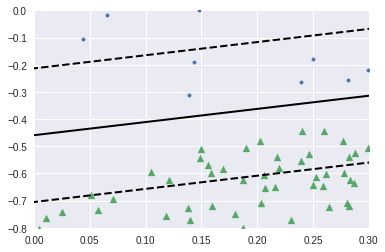

In [13]:
plt.scatter(Xa_train_scaled[y_train==0], ya_train_scaled[y_train==0], marker='.')
plt.scatter(Xa_train_scaled[y_train==1], ya_train_scaled[y_train==1], marker='^')
plot_decision_boundary(linear_svc_clf, -0.5, 0.5)
plt.xlim(-0, 0.3)
plt.ylim(-0.8, 0)
plt.show()

The model did pretty well but it seems that some margin violations have ocurred, let's quantify its score

In [14]:
y_preds = linear_svc_clf.predict(X_test_scaled)

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_scores(y_true, y_preds, avg='binary'):
    print(f'------ Model Scores ------')
    print(f'Accuracy: {accuracy_score(y_true, y_preds):.3f}')
    print(f'Precision: {precision_score(y_true, y_preds, average=avg):.3f}')
    print(f'Recall: {recall_score(y_true, y_preds, average=avg):.3f}')
    print(f'F1:  {f1_score(y_true, y_preds, average=avg):.3f}')

In [16]:
print_scores(y_test, y_preds)

------ Model Scores ------
Accuracy: 0.998
Precision: 0.997
Recall: 1.000
F1:  0.998


Now let's compare it against other models

In [17]:
from sklearn.svm import  SVC
from sklearn.linear_model import SGDClassifier

svc_clf = SVC(kernel='linear', random_state=14)
sgd_clf = SGDClassifier()

svc_clf.fit(X_train_scaled, y_train)
sgd_clf.fit(X_train_scaled, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [18]:
y_hat_svc = svc_clf.predict(X_test_scaled)
print_scores(y_test, y_hat_svc)

------ Model Scores ------
Accuracy: 0.997
Precision: 0.994
Recall: 1.000
F1:  0.997


In [19]:
y_hat_sgd = sgd_clf.predict(X_test_scaled)
print_scores(y_test, y_hat_sgd)

------ Model Scores ------
Accuracy: 0.998
Precision: 0.997
Recall: 1.000
F1:  0.998


All the models had excellent perfomance, but this is a simple dataset so this was expected

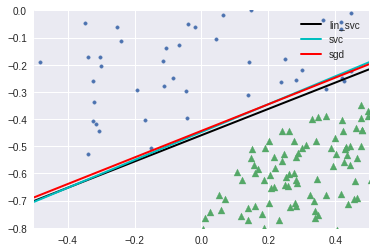

In [20]:
plt.scatter(Xa_train_scaled[y_train==0], ya_train_scaled[y_train==0], marker='.')
plt.scatter(Xa_train_scaled[y_train==1], ya_train_scaled[y_train==1], marker='^')

plot_decision_boundary(linear_svc_clf, -0.5, 0.5, color='k', label='lin_svc', plot_gutter=False)
plot_decision_boundary(svc_clf, -0.5, 0.5, color='c', label='svc', plot_gutter=False)
plot_decision_boundary(sgd_clf, -0.5, 0.5, color='r', label='sgd', plot_gutter=False)

plt.legend()
plt.xlim(-0.5, 0.5)
plt.ylim(-0.8, 0)
plt.show()

# 9) Train an SVM on the MNIST dataset

In [21]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

In [22]:
X, y = mnist['data'], mnist['target']

In [23]:
X.shape, y.shape

((70000, 784), (70000,))

Recall the mnist dataset is already shuffled and we typically pick the first 60k records for training leaving the rest for testing

In [24]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [25]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Hyperparameter search
Let's do a hyperparameter search on a small subset, for quick results

In [26]:
X_train_scaled_sub = X_train_scaled[:2000]
y_train_sub = y_train[:2000]
X_test_scaled_sub = X_test_scaled[:2000]
y_test_sub = y_test[:2000]

In [27]:
from sklearn.model_selection import GridSearchCV

svc_clf = SVC()
svc_param_grid = [{
    'C': np.r_[3:10], 
    'kernel': ['linear', 'rbf'], 
    'gamma': ['scale', 'auto'], 
    'decision_function_shape': ['ovr', 'ovo']
}]

svc_grid_search = GridSearchCV(svc_clf, svc_param_grid, cv=3,
                               scoring='accuracy', verbose=1)
svc_grid_search.fit(X_train_scaled_sub, y_train_sub)

Fitting 3 folds for each of 56 candidates, totalling 168 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 168 out of 168 | elapsed:  4.9min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': array([3, 4, 5, 6, 7, 8, 9]),
                          'decision_function_shape': ['ovr', 'ovo'],
                          'gamma': ['scale', 'auto'],
                          'kernel': ['linear', 'rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

Quick check on how the best params performs on the small test sample

In [28]:
best_svc = svc_grid_search.best_estimator_
y_pred_sub = best_svc.predict(X_test_scaled_sub)
print_scores(y_test_sub, y_pred_sub, 'macro')

------ Model Scores ------
Accuracy: 0.877
Precision: 0.880
Recall: 0.876
F1:  0.877


Let's see what the results for other parameters

In [29]:
drop_cols = ['mean_fit_time', 'std_score_time', 'std_fit_time', 'mean_score_time', 'params']
grid_search_results = (
    pd
    .DataFrame(svc_grid_search.cv_results_)
    .sort_values(['rank_test_score'])
)
grid_search_results.drop(drop_cols, axis=1).head()

,param_C,param_decision_function_shape,param_gamma,param_kernel,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
23,5,ovo,auto,rbf,0.890555,0.872564,0.915916,0.893011,0.017784,1
19,5,ovr,auto,rbf,0.890555,0.872564,0.915916,0.893011,0.017784,1
27,6,ovr,auto,rbf,0.889055,0.872564,0.915916,0.892512,0.017866,3
31,6,ovo,auto,rbf,0.889055,0.872564,0.915916,0.892512,0.017866,3
21,5,ovo,scale,rbf,0.890555,0.869565,0.915916,0.892012,0.018951,5


Looks like the score for the highest ranked parameters is very close, we'll train the full model with a few of these options and see which ones perform best on the full set.

Let's pick the two best parameters using OVR

In [30]:
ovr_mask = grid_search_results['param_decision_function_shape'] =='ovr'
top2_mask = grid_search_results['rank_test_score'] <= 3

param_list = grid_search_results['params'][ovr_mask & top2_mask].tolist()

Let's try using RandomizedSearchCV as well

In [31]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from sklearn.utils.fixes import loguniform

rand_param_grid = [
    {
        'C': stats.expon(scale=100),
        'kernel': ['poly', 'rbf'], 
        'degree': stats.uniform(3, 15),
        'gamma': stats.expon(0.1),
        'decision_function_shape': ['ovr', 'ovo']
    },
    {
        'C': loguniform(1, 10000),
        'kernel': ['poly', 'rbf'], 
        'degree': stats.uniform(3, 15),
        'gamma': stats.expon(0.1),
        'decision_function_shape': ['ovr', 'ovo']
    },
    {
        'C': stats.uniform(20, 70),
        'kernel': ['poly', 'rbf'], 
        'degree': stats.uniform(3, 15),
        'gamma': stats.expon(0.1),
        'decision_function_shape': ['ovr', 'ovo']
    }
]
rand_search = RandomizedSearchCV(SVC(), rand_param_grid, scoring='accuracy',
                                 cv=3, verbose=1, n_iter=10, random_state=14)
rand_search.fit(X_train_scaled_sub, y_train_sub)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.1min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                 class_weight=None, coef0=0.0,
                                 decision_function_shape='ovr', degree=3,
                                 gamma='scale', kernel='rbf', max_iter=-1,
                                 probability=False, random_state=None,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions=[{'C': <scipy.stat...
                                        {'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbc72ddd908>,
                                         'decision_function_shape': ['ovr',
                                                                     'ovo'],
                                         'degree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbc72ddd278>,
         

In [32]:
rand_best_svc = rand_search.best_estimator_
y_pred_sub = rand_best_svc.predict(X_test_scaled_sub)
print_scores(y_test_sub, y_pred_sub, 'macro')

------ Model Scores ------
Accuracy: 0.879
Precision: 0.888
Recall: 0.878
F1:  0.879


In [33]:
drop_cols = ['mean_fit_time', 'std_score_time', 'std_fit_time', 'mean_score_time', 'params']
rand_search_results = (
    pd
    .DataFrame(rand_search.cv_results_)
    .sort_values(['rank_test_score'])
)
rand_search_results.drop(drop_cols, axis=1).head(10)

,param_C,param_decision_function_shape,param_degree,param_gamma,param_kernel,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
9,45.0205,ovr,3.59797,5.65786,poly,0.880060,0.854573,0.881381,0.872005,0.012338,1
4,144.028,ovo,4.67718,0.289956,poly,0.782609,0.736132,0.800300,0.773014,0.027061,2
2,164.238,ovo,6.7124,3.49106,poly,0.604198,0.556222,0.621622,0.594014,0.027653,3
0,148.353,ovo,8.49424,0.261349,poly,0.484258,0.446777,0.472973,0.468002,0.015700,4
7,1.77583,ovo,16.2521,0.184943,rbf,0.124438,0.122939,0.124625,0.124000,0.000755,5
6,126.75,ovo,16.3131,0.187029,rbf,0.124438,0.122939,0.123123,0.123500,0.000668,6
5,491.753,ovo,4.44897,0.225135,rbf,0.119940,0.118441,0.120120,0.119500,0.000753,7
1,25.1021,ovo,7.77427,0.874791,rbf,0.112444,0.110945,0.112613,0.112000,0.000750,8
3,7.51344,ovo,16.9884,0.568796,rbf,0.112444,0.110945,0.112613,0.112000,0.000750,8
8,575.337,ovo,5.84818,0.533288,rbf,0.112444,0.110945,0.112613,0.112000,0.000750,8


Looks like the polynomial kernel is also performing well, let's include it as well

In [34]:
param_list.append(rand_search_results.loc[9, 'params'])

In [35]:
# Transform elements of dict to list so it fits GridSearchCV requirements
for model in param_list:
    for key in model.keys():
        if isinstance(model[key], list):
            pass
        else:
            model[key] = [model[key]]

In [36]:
param_list

[{'C': [5],
  'decision_function_shape': ['ovr'],
  'gamma': ['auto'],
  'kernel': ['rbf']},
 {'C': [6],
  'decision_function_shape': ['ovr'],
  'gamma': ['auto'],
  'kernel': ['rbf']},
 {'C': [45.020475427623595],
  'decision_function_shape': ['ovr'],
  'degree': [3.597966348668821],
  'gamma': [5.657855508009263],
  'kernel': ['poly']}]

With three sets of parameters ready to go, let's do a grid search on a slightly larger dataset and determine the best one

In [37]:
X_train_scaled_sub2 = X_train_scaled[:10000]
y_train_sub2 = y_train[:10000]
X_test_scaled_sub2 = X_test_scaled[:10000]
y_test_sub2 = y_test[:10000]

In [38]:
final_gs = GridSearchCV(SVC(), param_list, scoring='accuracy', cv=3, verbose=2)
final_gs.fit(X_train_scaled_sub2, y_train_sub2)

final_model = final_gs.best_estimator_
y_preds = final_model.predict(X_test_scaled_sub2)
print_scores(y_test_sub2, y_preds, 'macro')

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] C=5, decision_function_shape=ovr, gamma=auto, kernel=rbf ........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=5, decision_function_shape=ovr, gamma=auto, kernel=rbf, total=  36.7s
[CV] C=5, decision_function_shape=ovr, gamma=auto, kernel=rbf ........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   36.7s remaining:    0.0s


[CV]  C=5, decision_function_shape=ovr, gamma=auto, kernel=rbf, total=  36.8s
[CV] C=5, decision_function_shape=ovr, gamma=auto, kernel=rbf ........
[CV]  C=5, decision_function_shape=ovr, gamma=auto, kernel=rbf, total=  34.5s
[CV] C=6, decision_function_shape=ovr, gamma=auto, kernel=rbf ........
[CV]  C=6, decision_function_shape=ovr, gamma=auto, kernel=rbf, total=  28.5s
[CV] C=6, decision_function_shape=ovr, gamma=auto, kernel=rbf ........
[CV]  C=6, decision_function_shape=ovr, gamma=auto, kernel=rbf, total=  28.8s
[CV] C=6, decision_function_shape=ovr, gamma=auto, kernel=rbf ........
[CV]  C=6, decision_function_shape=ovr, gamma=auto, kernel=rbf, total=  28.2s
[CV] C=45.020475427623595, decision_function_shape=ovr, degree=3.597966348668821, gamma=5.657855508009263, kernel=poly 
[CV]  C=45.020475427623595, decision_function_shape=ovr, degree=3.597966348668821, gamma=5.657855508009263, kernel=poly, total=  40.2s
[CV] C=45.020475427623595, decision_function_shape=ovr, degree=3.597966

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  5.2min finished


------ Model Scores ------
Accuracy: 0.957
Precision: 0.957
Recall: 0.956
F1:  0.956


Now that we found the best hyperparameters, let's train the model on the full set

In [39]:
svc_clf = SVC(**final_gs.best_params_)

In [40]:
svc_clf.fit(X_train_scaled, y_train)

SVC(C=45.020475427623595, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3.597966348668821,
    gamma=5.657855508009263, kernel='poly', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)

In [41]:
y_preds = svc_clf.predict(X_test_scaled)
print_scores(y_test, y_preds, 'macro')

------ Model Scores ------
Accuracy: 0.978
Precision: 0.978
Recall: 0.978
F1:  0.978


Pretty good scores! Comparing it to the KNN model created for exercises 3 we're winning by 0.02 on all metrics

## 10) Train an SVM Regressor on the California Housing dataset

Let's build on the work done on chapter two and use the pre-processing and features that was done there to build our model

Load the data, bin income and perform stratified shuffle split of the data. We won't using income_cat as a variable so we drop it again

In [98]:
import os
from sklearn.model_selection import StratifiedShuffleSplit

def load_housing_data(housing_path):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

housing = load_housing_data('datasets/housing')
housing['income_cat'] = pd.cut(housing['median_income'],
                               bins=[0, 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1,2,3,4,5])

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=460)
for train_idx, test_idx in split.split(housing, housing['income_cat']):
    X_strat_train = housing.loc[train_idx]
    X_strat_test = housing.loc[test_idx]

X_strat_train.drop(['income_cat'], axis=1, inplace=True)
X_strat_test.drop(['income_cat'], axis=1, inplace=True)

The following class creates new features we'll use

In [90]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [110]:
X_train = X_strat_train.drop(['median_income'], axis=1)
y_train = X_strat_train['median_income']

X_test = X_strat_test.drop(['median_income'], axis=1)
y_test = X_strat_test['median_income']

In [111]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

cat_attributes = ['ocean_proximity']
num_attributes = list(X_train.drop(cat_attributes, axis=1))

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attributes),
    ('cat', OneHotEncoder(), cat_attributes)
])
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)

Now we're ready to train the SVM

In [152]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import LinearSVR, SVR

lin_params = [
    {
        'C':[1, 10, 100, 1000], 
        'dual':[False], 
        'epsilon': [0, 1, 5], 
        'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']
    }
]
svr_params = [
    {
        'C':[1, 10, 100, 1000], 
        'kernel': ['poly', 'rbf'],
        'epsilon': [0, 1, 5], 
        'degree': [3, 5, 13],
        'gamma': ['scale', 'auto'],
        'max_iter': [-1]
    }
]

lin_gs = GridSearchCV(LinearSVR(), lin_params, scoring='neg_mean_squared_error', 
                      cv=3, verbose=1, n_jobs=-1)
svr_gs = GridSearchCV(SVR(), svr_params, scoring='neg_mean_squared_error', 
                      cv=3, verbose=1, n_jobs=-1)

In [148]:
lin_gs.fit(X_train_prepared, y_train)

drop_cols = ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'params', 'param_dual']
lin_svr = lin_gs.best_estimator_

pd.DataFrame(lin_gs.cv_results_).sort_values(['rank_test_score']).drop(drop_cols, axis=1)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    0.8s finished


,param_C,param_epsilon,param_loss,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,1,0,squared_epsilon_insensitive,-1.190117,-1.174730,-1.137916,-1.167588,0.021901,1
7,10,0,squared_epsilon_insensitive,-1.190000,-1.174774,-1.138011,-1.167595,0.021823,2
19,1000,0,squared_epsilon_insensitive,-1.189988,-1.174782,-1.138022,-1.167597,0.021815,3
13,100,0,squared_epsilon_insensitive,-1.189993,-1.174781,-1.138021,-1.167599,0.021817,4
3,1,1,squared_epsilon_insensitive,-1.189533,-1.214389,-1.186998,-1.196973,0.012358,5
9,10,1,squared_epsilon_insensitive,-1.189456,-1.214420,-1.187068,-1.196981,0.012369,6
15,100,1,squared_epsilon_insensitive,-1.189448,-1.214428,-1.187084,-1.196987,0.012371,7
21,1000,1,squared_epsilon_insensitive,-1.189450,-1.214433,-1.187086,-1.196989,0.012372,8
5,1,5,squared_epsilon_insensitive,-2.964026,-5.508516,-4.926337,-4.466293,1.088527,9
17,100,5,squared_epsilon_insensitive,-4.148405,-5.565889,-5.202484,-4.972259,0.601148,10


In [ ]:
svr_gs.fit(X_train_prepared, y_train)

drop_cols = ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'params']
svr_reg = svr_gs.best_estimator_

pd.DataFrame(svr_gs.cv_results_).sort_values(['rank_test_score']).drop(drop_cols, axis=1)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 20.5min
